In [2]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value, ±
using Graphs
using JLD2
include("meanfield.jl");

In [3]:
N = 10^3
seed = 1
rng = MersenneTwister(seed)
gg = prufer_decode(rand(rng, 1:N, N-2))
g = IndexedGraph(gg)
T = 50     # final time
Δt = 1.0   # discretization
λ = 0.3    # prob. of transmission
ρ = 0.2   # prob. of recovery

j = argmax(degree(g,j) for j in vertices(g))
γ = [i==j ? 1.0 : 0.0 for i in 1:N]

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt); γ)

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [4]:
j

395

In [11]:
# using GraphRecipes, ColorSchemes
# cg = cgrad(:matter)
# graphplot(gg, nodeshape=:circle, curves=false, nodecolor=[cg[1-j] for j in γ])

In [ ]:
k = 12
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-6

# run MPBP
reset!(bp)
cb = CB_BP(bp)
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [ ]:
# compute marginals
p_bp = means((x,i)->x-1, bp);

## Monte Carlo

In [ ]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [ ]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
rng = MersenneTwister(1)
nsamples_mc = 10^5
sample!(sms, nsamples_mc; rng);

In [ ]:
b_mc = marginals(sms)
p_mc = [[value(bb[INFECTIOUS]/sum(bb)) for bb in b] for b in b_mc];

### Discretized mean field methods

In [ ]:
include("meanfield.jl");
using UnPack
fn = "sis_compare_meanfield_tree"
data = load("plot_data/"*fn*".jld2")
@unpack T, N, j, λ, ρ, γ, p_bp, p_mc, p_ibmf_disc, p_dmp_disc = data;

In [ ]:
p_dmp_disc, = dmp_disc(T, Δt, bp.g, λ, ρ, γ)     
p_ibmf_disc = ibmf_disc(T, Δt, bp.g, λ, ρ, γ)
p_cme_disc, = cme_disc(T, Δt, bp.g, λ, ρ, γ);

In [ ]:
r_bp = cor(reduce(vcat, p_bp), value.(reduce(vcat, p_mc)))
r_dmp_disc = cor(reduce(vcat, p_dmp_disc), value.(reduce(vcat, p_mc)))
r_ibmf_disc = cor(reduce(vcat, p_ibmf_disc), value.(reduce(vcat, p_mc)))
r_cme_disc = cor(reduce(vcat, p_cme_disc), value.(reduce(vcat, p_mc)))
r_bp, r_dmp_disc, r_ibmf_disc, r_cme_disc

In [ ]:
pl_sc = [(scatter(reduce(vcat, p_mc), reduce(vcat, p), ylabel=xlab, xlabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:bottomright, titlefontsize=10,
            title="Pearson=$(round(cor(reduce(vcat, p), value.(reduce(vcat, p_mc))), digits=5))");
        plot!(identity, c=:red, ls=:dash, lw=1)) for (p, xlab) in 
        zip([p_bp, p_dmp_disc, p_ibmf_disc, p_cme_disc], ["MPBP", "DMP", "IBMF", "CME"])]
plot(pl_sc..., size=(800,200), margin=5Plots.mm, layout=(1,4));

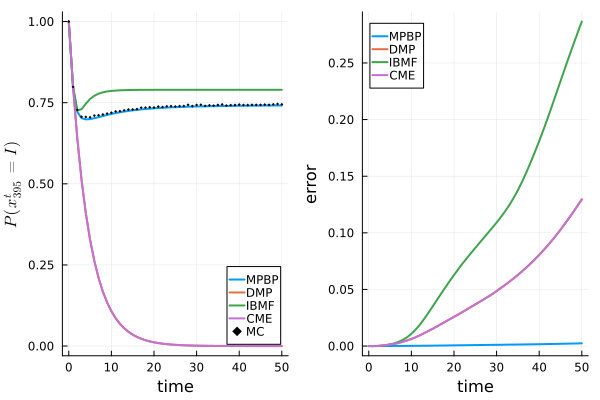

In [17]:
Plots.default(lw=2)
i = j
pl = plot(xlabel="time", ylabel=L"P(x_{%$i}^t=I)", legend=:bottomright)
plot!(pl, 0:Δt:T, p_bp[i], label="MPBP")
plot!(pl, 0:Δt:T, p_dmp_disc[i], label="DMP")
plot!(pl, 0:Δt:T, p_ibmf_disc[i], label="IBMF")
plot!(pl, 0:Δt:T, p_cme_disc[i], label="CME")
scatter!(pl, 0:Δt:T, value.(p_mc[i]), c=:black, m=:diamond, ms=1.5, label="MC")

err_bp = [mean(abs(p_bp[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_dmp_disc = [mean(abs(p_dmp_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_ibmf_disc = [mean(abs(p_ibmf_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]
err_cme_disc = [mean(abs(p_cme_disc[i][t]-p_mc[i][t]) for i in 1:N) for t in 1:T+1]

plot!(pl, inset=(1, bbox(0.3, 0.25, 0.5, 0.6)), subplot=2)
plot!(pl[2], xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl[2], 0:Δt:T, err_bp, label="MPBP")
plot!(pl[2], 0:Δt:T, err_dmp_disc, label="DMP")
plot!(pl[2], 0:Δt:T, err_ibmf_disc, label="IBMF")
plot!(pl[2], 0:Δt:T, err_cme_disc, label="CME")
plot(plot(pl[1]), plot(pl[2]))

In [ ]:
# jldsave("plot_data/sis_compare_meanfield_tree.jld2"; T, N, j, λ, ρ, γ, p_bp, p_mc, p_ibmf_disc, p_dmp_disc,
#     p_cme_disc);